<a href="https://colab.research.google.com/github/janchorowski/ml_uwr/blob/fall2020/lectures/09_adabost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning @ UWr 2020

**Lecture 09**

During the last lecture we have seen how Decision Trees can be used to learn simple if-else models. A sufficiently deep tree can express any relation between the target and the features. However, nodes in deep trees are fitted to smaller and smaller datasets and the tree building process becomes noisy.

The Random Forest resolved this issue by embracing randomness: several trees were built, and their results averaged. To work well, the forest required that individual trees fit well the data (hence they are often unpruned) and that they are different, which was achieved by injecting randomness into the tree growing process.

In the ideal ensembling scenario, individual classifiers are strong and make mistakes on different examples, making the ensemble more accurate than any tree on its constituents.


# Boosting Weak Classifiers

Today we will consider the case when individual classififers are barely better than chance. We will call them _weak learners_. By itself, their ensemble will most often not work because the simple classifiers will be correlated, and their errors will overlap. Classifier boosting began with a theoretical question:

> Is it possible to combine weak classifiers (only slightly better than random guessing) into a strong classifer (training error rate is arbitrarily low)?

As we will see the answer is positive. The main intuition is that we can't simply inject randomness and hope that weak classifiers will be decorrelated enough to drive the overall error down, like we did in the case of Random Forest. Instead, we will build the ensemble sequentially. Each classifier will be trained to improve on the output of the classifiers added so far. By forcing the classifiers to correct the mistakes performed by the previous ones, we can drive the overall training error low.

As such, boosting is not concerned with overfitting and reducing classifier variance, but with modeling complex decision boundaries when the available learners can only produce simple ones. However, it was found to produce models which generalize well. In fact, boosted Decision Trees are extremely good classifiers, probably the best general-purpose ones.

We will first see how boosting works on a few examples. Then we will prove that it does indeed lower the trainng error. Next, we will look at boosting from a function optimization viewpoint, culminating in XGBoost, a very successful boosting implementation that has won several Kaggle contests.

## AdaBoost Intuitions

The gist of the AdaBoost algorithm implements these steps:
1. Start with an empty ensemble, assign uniform weights to all samples in the dataset.
2. In a loop:
    1. Train a classifier on the weighted data
    2. Add it to the ensemble, possibly with a weight
    3. Score the training dataset with the ensemble, increase the weigths of incorrectly classified examples, decrease the weights of correctly classified ones

The final scoring function is a weighted combination of classifiers built in all rounds:
$$
F(x) = \alpha_1 f_1(x) + \alpha_2 f_2(x) + \alpha_3 f_3(x) + \ldots
$$
For a binary classification problem the final classification rule is 
$$
H(X) = \mathrm{sign}(F(X))
$$

### Examples

In the example below the weak learner is the Desicion Tree Stump (a tree with only one split). 

We train the first weak classifier on all data with uniform weights.

We then increase the weight of misclassified examples and decrease the weight of correctly classified ones. A new classifier is thus trained to pay more attention to the errors of the previous ones.

Notice that the final decision boundary is impossible to express as a single Decision Tree Stump.


In [ ]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets, linear_model, model_selection, svm, tree

In [ ]:
# @title Utility funs


def get_grid(X):
    Grid = np.meshgrid(
        np.linspace(X[:, 0].min() - 0.1, X[:, 0].max() + 0.1, 50),
        np.linspace(X[:, 1].min() - 0.1, X[:, 1].max() + 0.1, 50),
    )
    XGridFlat = np.concatenate(
        (Grid[0].reshape(-1, 1), Grid[1].reshape(-1, 1)), axis=-1
    )
    return Grid, XGridFlat


def plot_data(X, Y, W=None, XGrid=None, YGrid=None):
    pal2 = sns.color_palette("Set1")[:2]
    if XGrid is not None:
        plt.contourf(
            XGrid[0],
            XGrid[1],
            YGrid.reshape(XGrid[0].shape),
            cmap="Set1",
            vmin=-1,
            vmax=9,
            alpha=0.7,
        )
    sns.scatterplot(x=X[:, 0], y=X[:, 1], size=W, hue=Y, palette=pal2)
    plt.axis("square")
    plt.xlim(X[:, 0].min() - 0.1, X[:, 0].max() + 0.1)
    plt.ylim(X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)

    # Remove size from legend
    ax = plt.gca()
    # EXTRACT CURRENT HANDLES AND LABELS
    h, l = ax.get_legend_handles_labels()

    # COLOR LEGEND (FIRST 30 ITEMS)
    col_lgd = plt.legend(h[:2], l[:2], loc="upper right")


def plot_boost_round(t, X, Y, W_old, XGrid, weak_preds, adaboost_preds):
    plt.figure(figsize=(9, 2))
    plt.subplot(1, 2, 1)
    plot_data(X, Y, W_old, XGrid, weak_preds)
    plt.title(f"Weak classifier {t}\n(old sample weights)")

    plt.subplot(1, 2, 2)
    plot_data(X, Y, W_old, XGrid, adaboost_preds)
    plt.title(f"Boosting round {t}\n(updated sample weights)")

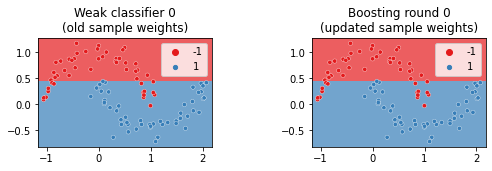

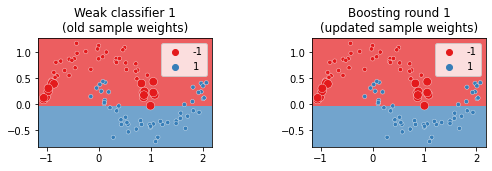

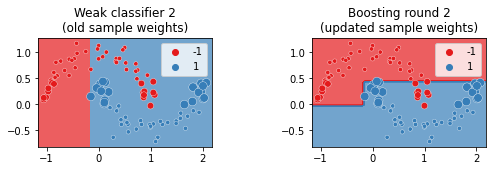

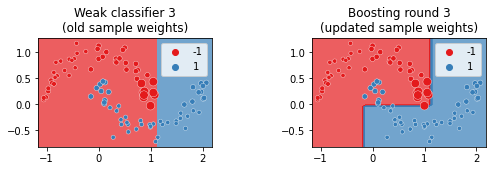

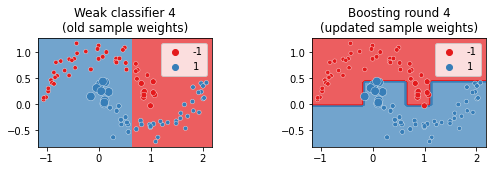

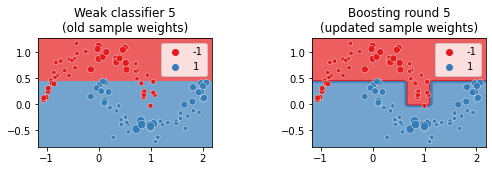

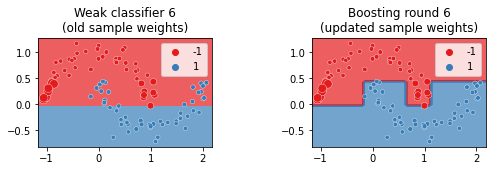

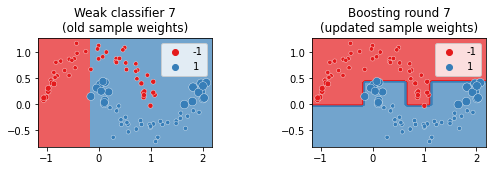

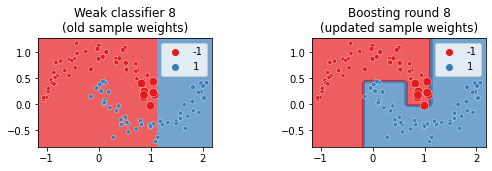

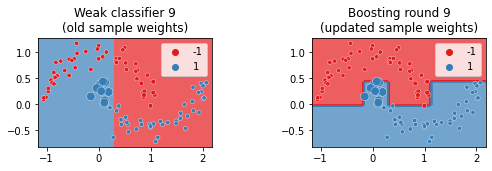

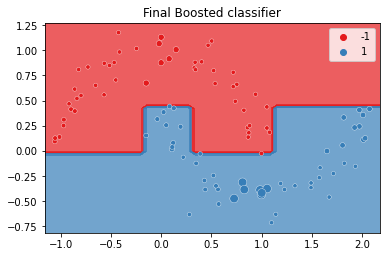

In [ ]:
# @title Demo

# Moons data
X, Y = datasets.make_moons(noise=0.1)
Y = Y * 2 - 1  # Make Y +1 or -1

T = 10
W = np.ones(Y.shape)

XGrid, XGridFlat = get_grid(X)
grid_scores = 0
Y_scores = 0

H = []
train_errs = []

for t in range(T):
    f_t = tree.DecisionTreeClassifier(max_depth=1).fit(X, Y, W)
    err_t = ((f_t.predict(X) != Y) * W).mean()
    alpha_t = 0.5 * np.log((1 - err_t) / err_t)
    W_old = W
    W = W_old * np.exp(-alpha_t * Y * f_t.predict(X))

    grid_scores += alpha_t * f_t.predict(XGridFlat)

    plot_boost_round(
        t, X, Y, W_old, XGrid, f_t.predict(XGridFlat), np.sign(grid_scores)
    )

plt.figure()
plot_data(X, Y, W, XGrid, np.sign(grid_scores))
plt.title(f"Final Boosted classifier")
None

In [ ]:
W_old.shape

(100,)

## Adaboost Details


Assume that the classes are binary, and encode them as $Y\in\{+1, -1\}$. We will perform $T$ rounds of boosting, building the weak classifier $f_t(X)$ in the $t$-th round and adding it to the ensemble classifier  $F_t(x) = \sum_{t'=1}^{t}\alpha_{t'} f_{t'}(x)$.

The AdaBoost algorithm works as follows:

1. Initialization:
    1. $w_1^i=1$  (assign equal weight to all samples in the dataset)

    2. $F_0(x) = 0$

2. for $t=1,...,T$:
    1. $f_t=$ a weak classifier trained on data weighted by $w_t$
    
    2. $\epsilon_t = \frac{\sum_i w_t^i [f_t(x^i) \neq y^i]}{\sum_i w_t^i}$ ($\epsilon_t$ is the weighted error rate of $f_t$)
    
    3. $\alpha_t = \frac{1}{2}\log\frac{1-\epsilon_t}{\epsilon_t}$ (note that we require that $\epsilon_t < 0.5$  which implies $\alpha_t > 0$).

    4. $F_t(x) = F_{t-1}(x) + \alpha_t f_t(x)$
    
    5. $w_{t+1} = e^{-y^i F_t(x^i)}$ (reweight the data).

       Notice that this changes the weights to concentrate on badly classified samples:
$$
\begin{split}
    w_{t+1} &= e^{-y^i F_t(x^i)} = e^{-y^i \sum_{t'=1}^t \alpha_{t'} f_{t'}(x^i)} = \\
    &= w_t \cdot e^{-y^i\alpha_t t_f(x^i)} \\
    &= w_t \begin{cases}
    e^{-\alpha_t} &\text{ if } y^i = f_t(x^i) \\
    e^{\alpha_t}  &\text{ if } y^i \neq f_t(x^i) 
    \end{cases}
\end{split}
$$

3. Return final classifier $H(x) = \text{sign}(F_t(x))$



We show below the relationship between $\epsilon_t$ and $\alpha_t$. We can observe that perfect classifiers would get an infinitely large weight, while a random classifier would get a weight 0, which would effectively remove it from the ensemble.

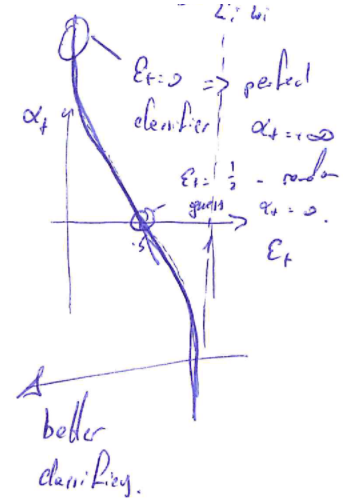

#### Multiplicative Weight Update : 
the way Adaboost updates its weights is an example of a much more general framework: [Multiplicative weight update](https://en.wikipedia.org/wiki/Multiplicative_weight_update_method), which has found many applications across Computer Science. An early example of MWU in action we could have seen in Bayesian classifiers.

### Additional demonstrations

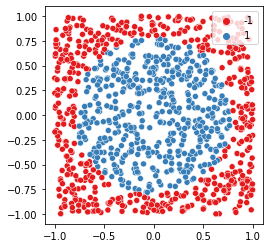

In [ ]:
# Generate a nonlinearly separable dataset

# Circle dataset
X = np.random.rand(1000, 2) * 2 - 1
Y = (X ** 2).sum(-1) < (2 / np.pi)
Y = Y * 2 - 1

plot_data(X, Y)

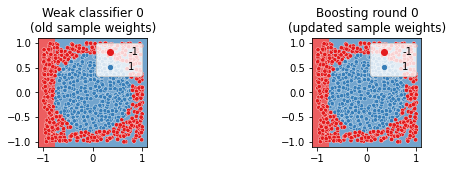

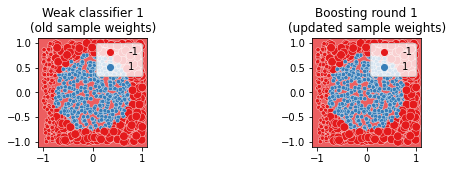

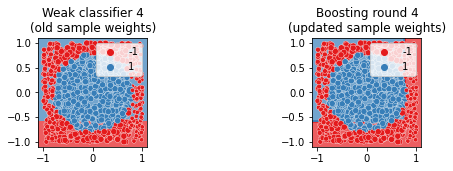

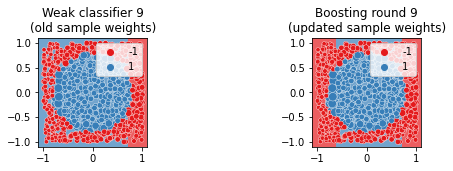

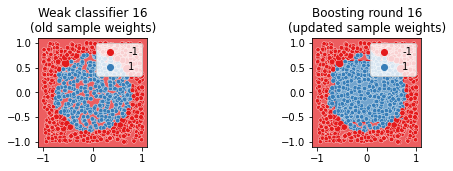

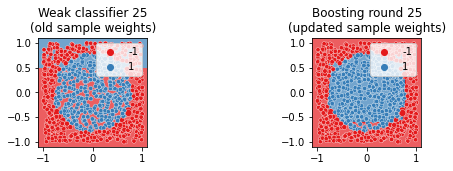

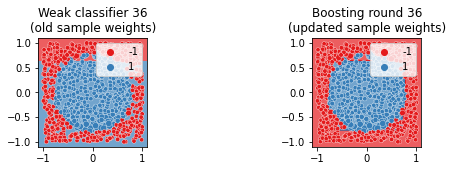

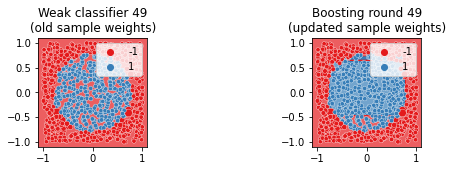

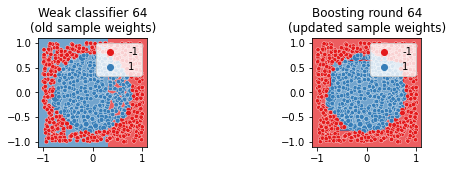

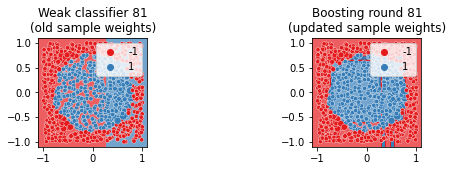

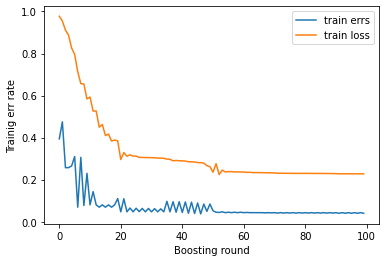

In [ ]:
T = 100
W = np.ones(Y.shape)

grid_scores = 0
Y_scores = 0

H = []
train_errs = []
train_loss = []

XGrid, XGridFlat = get_grid(X)

for t in range(T):
    f_t = tree.DecisionTreeClassifier(max_depth=1).fit(X, Y, W)
    err_t = ((f_t.predict(X) != Y) * W).mean()
    if err_t > 0.5:
        print("No weak classifier found")
        break
    alpha_t = 0.5 * np.log((1 - err_t) / err_t)
    H.append((alpha_t, f_t))
    W_old = W
    W = W_old * np.exp(-alpha_t * Y * f_t.predict(X))

    grid_scores += alpha_t * f_t.predict(XGridFlat)
    Y_scores += alpha_t * f_t.predict(X)

    train_loss.append(np.exp(-Y_scores * Y).mean())
    train_errs.append((np.sign(Y_scores) != Y).mean())
    if np.ceil(np.sqrt(t)) != np.ceil(np.sqrt(t + 1)):
        plot_boost_round(
            t, X, Y, W_old, XGrid, f_t.predict(XGridFlat), np.sign(grid_scores)
        )

plt.figure()
plt.plot(train_errs, label="train errs")
plt.plot(train_loss, label="train loss")
plt.xlabel("Boosting round")
plt.ylabel("Trainig err rate")
plt.legend()

### Real data example

In [ ]:
german_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric",
    names=[f"A{d}" for d in range(1, 25)] + ["target"],
    header=None,
    sep="\s+",
)
# Targets are 1&2, change to -1&+1
german_df["target"] = german_df["target"] * 2 - 3

german_train_df, german_test_df = model_selection.train_test_split(
    german_df, test_size=0.3
)
X = np.array(german_train_df[german_df.columns[:-1]])
Y = np.array(german_train_df["target"])

testX = np.array(german_test_df[german_df.columns[:-1]])
testY = np.array(german_test_df["target"])

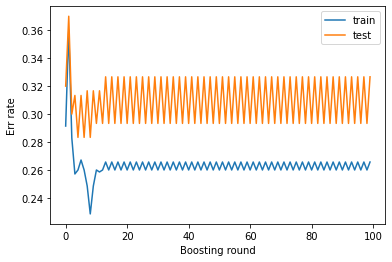

In [ ]:
T = 100
W = np.ones(Y.shape)

H = []

Y_scores = 0
train_errs = []
train_loss = []

testY_scores = 0
test_errs = []

for t in range(T):
    f_t = tree.DecisionTreeClassifier(max_depth=1).fit(X, Y, W)
    err_t = ((f_t.predict(X) != Y) * W).mean()
    if err_t > 0.5:
        print("No weak classifier found")
        break
    alpha_t = 0.5 * np.log((1 - err_t) / err_t)
    H.append((alpha_t, f_t))
    W *= np.exp(-alpha_t * Y * f_t.predict(X))

    Y_scores += alpha_t * f_t.predict(X)
    train_errs.append((np.sign(Y_scores) != Y).mean())
    train_loss.append(np.exp(-Y_scores * Y).mean())

    testY_scores += alpha_t * f_t.predict(testX)
    test_errs.append((np.sign(testY_scores) != testY).mean())

plt.figure()
plt.plot(train_errs, label="train")
# plt.plot(train_loss, label='train loss')
plt.plot(test_errs, label="test")
plt.xlabel("Boosting round")
plt.ylabel("Err rate")
_ = plt.legend()

# Boosting as Optimization

We will now learn the connection between AdaBoost and learning methods such as regressions that optimize loss functions. We will first show that AdaBoost optimizes a particular loss function. We will then see how to design generic boosting algorithms which optimize any loss function.

## AdaBoost Optimizes a Loss Function

We will now prove, that AdaBoost provably reduces the training error in each round during which a weak classifier is found.

We will first show that AdaBoost is in fact minimizing a loss function, $L=\frac{1}{N}\sum_{i=1}^N e^{-y^i F(x^i)}$. Define $L_t$ to be the loss after the $t$-th iteration:
$$
\begin{split}
L_t &= \frac{1}{N}\sum_{i=1}^N e^{-y^i F_t(x^i)}  = \frac{1}{N}\sum_{i=1}^N e^{-y^i \sum_{t'=1}^t\alpha_{t'} f_{t'}(x^i)} \\
&= \frac{1}{N}\sum_{i=1}^N e^{-y^i F_{t-1}(x^i)}e^{- y^i \alpha_t f_t(x^i)} \\
&= \frac{1}{N}\sum_{i=1}^N w_t^i e^{- y^i \alpha_t f_t(x^i)} \\
&= \frac{1}{N}\left[ 
    \sum_{i:y^i = H_t(x^i)} w_t^i e^{-\alpha_t} +
    \sum_{i:y^i \neq H_t(x^i)} w_t^i e^{\alpha_t} +
    \sum_{i:y^i \neq H_t(x^i)} \left( w_t^i e^{-\alpha_t} - w_t^i e^{-\alpha_t} \right)
    \right] \\
&= \frac{1}{N}\left[
    \sum_i w_t^i e^{-\alpha_t} + \sum_{i:y^i \neq H_t(x^i)} w_t^i \left( e^{\alpha_t} - e^{-\alpha_t}\right)
    \right] 
\end{split}
$$

Let's try to minimize this expression over $\alpha_t$ and $f_t(x)$! A couple of observations:
1. $\sum_i w_t^i e^{-\alpha_t}$ doesn't depend on $f_t$, classifier chosen in round $t$
2. For any $\alpha_t > 0$ we get $\left(e^{\alpha_t} - e^{-\alpha_t}\right)$ is a positive constant: $\left(e^{\alpha_t} - e^{-\alpha_t}\right) = \textrm{const} > 0$.

Thus, we can do the minimization in two steps:
1. First, choose the optimal $f_t(x)$. It has to minimize $\sum_{i:y^i \neq H_t(x^i)} w_t^i$, or in other words make the smallest amount of weighted errors. This is exactly what AdaBoost does when it trains a weak classifier!
2. Having chosen an $f_t(x)$, choose its optimal $\alpha_t$ under the constraint $\alpha_t > 0$.

It is straightforward (and left as a homework exercise) to show that the optimal $\alpha_t = \frac{1}{2}\log\frac{1-\epsilon_t}{\epsilon_t}$, which corresponds to AdaBoost operation.

### Reducing exponential loss reduces error rate

Finally, we will show that the exponential loss bounds the error rate of the boosted classifier:

$$
\begin{split}
\text{err rate}_t &= \frac{1}{N}\sum_{1}^N [y^i \neq \mathrm{sign}(F_t(x^i))] \\
&= \frac{1}{N}\sum_{1}^N \begin{cases}
1 & \text{if } y^i \neq \mathrm{sign}(F_t(x^i)) \\
0 & \text{otherwise} \\
\end{cases} \\
&\leq \frac{1}{N}\sum_{1}^N \begin{cases}
e^{\alpha_t} & \text{if } y^i \neq \mathrm{sign}(F_t(x^i)) \\
e^{-\alpha_t} & \text{otherwise} 
\end{cases} \\
&= \frac{1}{N}\sum_{1}^N e^{-y^i F_t(x^i)} = L_t
\end{split}
$$

Thus the loss function minimized by AdaBoost upper-bounds the error rate of the boosted classifier.



### Relationship between AdaBoost's and Logistic Regression loss functions

We have just demonstrated that AdaBoost optimizes a loss function. We can compare it to the loss used by Logistic Regression.

Both AdaBoost and Logistic regression compute a score $h(x)$:
- In AdaBoost $F_{AB}(x) = \sum_t \alpha_t f_t(x)$, where $f_t$ is the $t-$th weak learner and $\alpha_t$ is its corresponding weigth.
- In Logistic Regression $F_{LR}(x) = \sum_j \Theta_j x_j$ with $\Theta$ a parameter vector.

Likewise, both methods have the same decision rule $y=1$ if and only if $F(x) \geq 0$.

Finally, both are trained to minimize a loss function:
- AdaBoost minimizes the exponential loss:
$$
\begin{cases}
e^{-F_{AB}(x)}&\text{ if }y=1 \\
e^{F_{AB}(x)}&\text{ if }y\neq 1
 \end{cases}
 =e^{-y F_{AB}(x)}
 $$ when $y\in\{-1, 1\}$
- Logistic Regression minimizes the $nll$:
$$
\begin{split}
nll &= \begin{cases}
-\log p(y=1|x)&\text{ if }y=1 \\
-\log(1 - p(y=1|x))&\text{ if }y\neq 1
\end{cases} \\
 &= -y \log p(y=1|x) - (1-y)\log(1 - p(y=1|x)) \\
 &= -y \log \sigma(F_{LR}(x)) - (1-y)\log(1 - \sigma(F_{LR}(x)))
\end{split}
$$ when $y\in\{0,1\}$.

To get a better insight into the relationship between the two functions we will find an alternative formulation for the Logistic Regression Loss.
$$
\begin{split}
nll &= \begin{cases}
-\log p(y=1|x)&\text{ if }y=1 \\
-\log(1 - p(y=1|x))&\text{ if }y\neq 1
\end{cases} \\
&= \begin{cases}
-\log \frac{1}{1+e^{-F_{LR}(x)}} &\text{ if }y=1 \\
-\log \frac{1}{1+e^{F_{LR}(x)}} &\text{ if }y\neq 1
\end{cases} \\
&= \log(1+e^{-y F_{LR}(x)})
\end{split}
$$ when $y\in\{-1, 1\}$.

Thus, we can alternatively view the logistic regression loss as $\log(1+e^{-y F_{LR}(x)})$ when targets are encoded into $\pm 1$.

Below we plot 3 loss functions for the case when $y=1$:
- the 0-1 loss $\text{sign}(F(x)) = 1$,
- the exponential loss from AdaBoost $e^{-yF(x)}$,
- the cross-entropy from Logistic Regression $\log(1+e^{-yF(x)})$

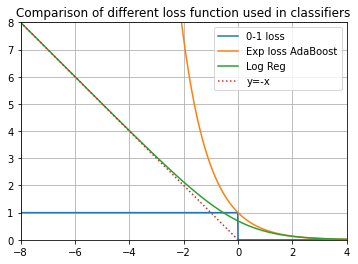

In [ ]:
h = np.linspace(-8, 4, 1000)
plt.plot(h, h < 0, label="0-1 loss")
plt.plot(h, np.exp(-h), label="Exp loss AdaBoost")
plt.plot(h, np.log(1 + np.exp(-h)), label="Log Reg")
plt.plot([h[0], 0], [-h[0], 0], ":", label="y=-x")
plt.axis("square")
plt.ylim(0, -h[0])
plt.xlim(h[0], h[-1])
plt.grid(True)
plt.title("Comparison of different loss function used in classifiers")
plt.legend()

As we can see, both exponential loss, and the logistic loss (after scaling) can be seen as convex upper bounds on the 0-1 loss:
- they both tend to zero if the model is confidently correct,
- they both grow to infinity if the model is confidently incorrect.

However, while logistic regression's loss grows linearly with the magnitude of the error,  Adaboost's loss grows exponentially fast. This has a practical implication: a model trained with the AdaBoost's loss will make more to avoid training misclassifications, which can make the model more prone to outliers.

Using the neg-log-likelihood in boosting is popular. It was developed in the [LogitBooost algorithm](https://projecteuclid.org/download/pdf_1/euclid.aos/1016218223). [XGBoost](https://en.wikipedia.org/wiki/XGBoost), a popular boosting framework that we describe below supports many other loss functions.

## Boosting the Least Squares Loss

We will now see how to use Boosting with other loss functions. To get some intuitions, let's apply tree boosting to regression with a least squares criterion.

Our model after $T$ rounds of boosting will again be a collection of weak learners (simple regressors) $f_t(x)$: 

$$
F_T(x) = \sum_{t=1}^T \alpha_t f_T(x).
$$

The loss at round $T$ is simply
$$
L_T = \sum_{i=1}^N \left(y^i - F_T(x^i)\right)^2.
$$

Let's rewrite the loss to highlight the contribution from the $T$-th

$$
L_T = \sum_{i=1}^N \left(y^i - F_T(x^i)\right)^2 = \sum_{i=1}^N \left(y^i - \sum_{t=1}^T \alpha_t f_t(x^i)\right)^2 = \sum_{i=1}^N \left((y^i - F_{T-1}(x^i)) - \alpha_T f_T(x^i)\right)^2 = \sum_{i=1}^N \left(r_T^i - \alpha_T f_T(x^i)\right)^2
$$
where we defined $r_T^i = (y^i - F_{T-1}(x^i))$ and $r_0^i = y^i$.

We can see that in this case boosting will consists of repeatedly fitting the residuals from previous models.

Let's see an example.

Text(0.5, 1.0, 'X-Y relation to learn')

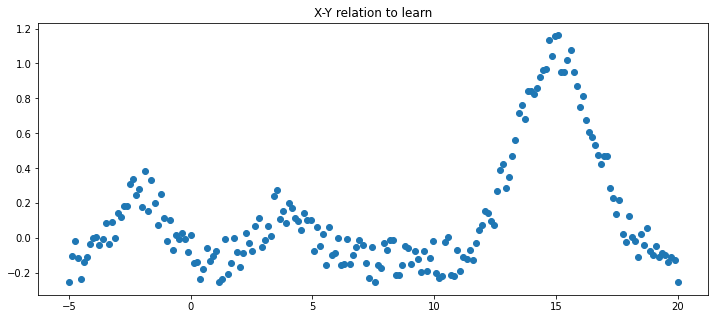

In [ ]:
# Data Generation
X = np.linspace(-5, 20, 200)
Y = (
    1 / np.sqrt(2 * np.pi) * np.exp(-((X + 2) ** 2) / (2))
    + 1 / np.sqrt(2 * np.pi) * np.exp(-((X - 4) ** 2) / (2)) * 0.8
    + 1 / np.sqrt(2 * np.pi) * np.exp(-((X - 15) ** 2) / (5)) * 3
)
Y -= np.mean(Y)

Y += np.random.rand(200) / 4

plt.figure(figsize=(12, 5))
plt.scatter(X, Y)
plt.title("X-Y relation to learn")

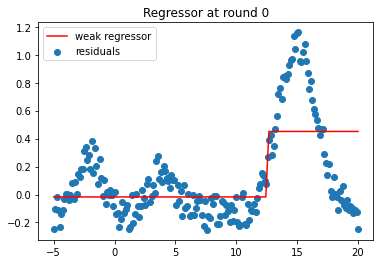

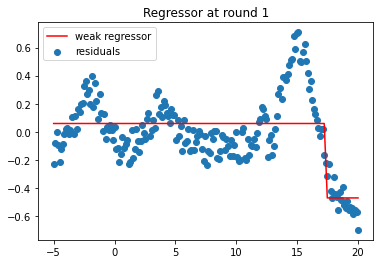

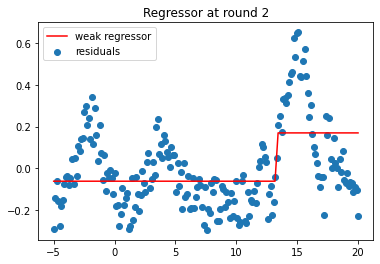

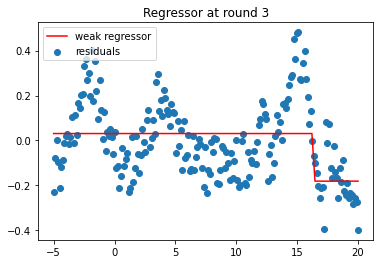

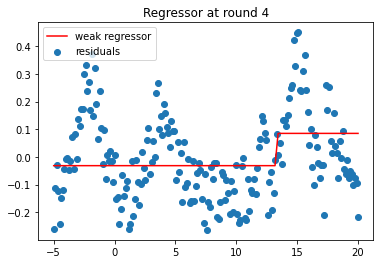

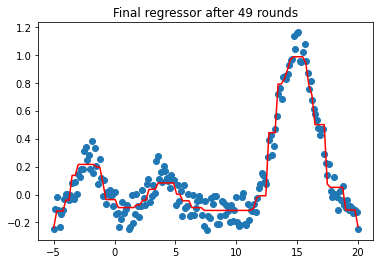

In [ ]:
T = 50
X_plot = np.linspace(X.min(), X.max(), 100)
final_preds = np.zeros_like(X_plot)

r = Y
for t in range(T):
    f_t = tree.DecisionTreeRegressor(criterion="mse", max_depth=1).fit(X[:, None], r)

    if t < 5:
        plt.figure()
        plt.scatter(X, r, label="residuals")
        plt.plot(
            X_plot, f_t.predict(X_plot[:, None]), label="weak regressor", color="r"
        )
        plt.title(f"Regressor at round {t}")
        plt.legend(loc="upper left")

    r = r - f_t.predict(X[:, None])
    final_preds = final_preds + f_t.predict(X_plot[:, None])

plt.figure()
plt.scatter(X, Y, label="data")
plt.plot(X_plot, final_preds, label="boosted model", color="r")
plt.title(f"Final regressor after {t} rounds")
None

## Generalizing Boosting to Other Loss Functions

**NB** Gradient Boosting is optional and it is not required to understand XGBoost below.

We were able to easily write a boosting algorithm for regression, because we already had decision trees which minimize the MSE loss. However, other loss functions, such as the negative log-likelihood from logistic regression, or robust regression losses such as Huber do not necessarily allow easy learning of weak learners that optimize them.

Suppose for a moment that our goal is to learn the values that our model should return at the training  data points. In other words, we treat $F$ as a vector 
$$
F = [F^1, F^2, ..., F^N]
$$
where $F_i$ is the desired output of our model for training sample $x^i$, and we keep using the upper index for sample enumeration.

Suppose we wish to minimize our loss function over the vector $F$:
$$
\min_F \frac{1}{N} \sum_{i=1}^N L(Y^i, F^i).
$$

To develop intuitions about the _gradient boosting method_ we will not simply set $F^i = Y^i$, but instead observe what gradient descent would do to find the vector $F$. The algorithm would work as follows:
1. Set the initial vector $F_0 = 0$  (i.e., $F_0$ is a vector of values associated with all data samples, i.e. a vector of $N$ zeros).
2. For $t$ in $1...T$:
    1. Compute the derivative $g_t = \frac{\partial L}{\partial F}$
    2. Set $F_t = F_{t-1} + \alpha_t g_t$

Thus we express the vector of model outputs $F$ by a sum of gradients of the loss function.

Gradient Boosting will approximate this procedure, however it will not store a vector of model responses, but it will compute them using a model expressed as a sum of learners:

1. $F_0(x) = 0$ the first model is empty and returns $0$ for all $x$.
2. For $t$ in $1...T$:
    1. Find an approximation to the derivative $\frac{\partial L}{\partial F}$:
        1. Compute the vector of derivatives of the loss with respect to model outputs on all training samples:
            $$ 
            r^i_t = \left[\frac{\partial L\left(y^i, F(x^i)\right)}{\partial F(x^i)}\right]^{F = F_{t-1}}
            $$
        2. Fit a regressor $f_t(x)$ to the vector of derivatives $r_t$: it will approximate the gradient on data samples.
    2. Set $F_t(x) = F_{t-1}(x) + \alpha_t f_t(x)$

Notice that gradient boosting is just an approximation to fitting a table of model outputs: since the model outputs for different samples are not independent (they are all computed by a model) we cannot arbitrarily change them. Thus the best we can do is to find an addition to the model, which would approximate the gradient! However, a table function doesn't generalize. Our boosted model does!

Please note, that for the square loss $\frac{\partial(y-f)^2}{\partial f} = 2(y-f)$ which means that gradient boosting applied to a mean squares criterion simply fits the regressor to the residuals from the previous stage, recovering the example above.

In the special case when the weak learner is a decision tree, we can fold the constants $\alpha$ into the tree. A tree assigns samples to leaf nodes, then returns the value associated with a given leaf. Rather than multiplying the values in all leaves by a single $\alpha$, we can re-learn the value in each leaf. In particular, assume that the tree fitted to gradients 
$r_t$ assigned each sample to one of $M$ leaves denoted $R_{t1},...,R_{tM}$, each returning the value $\omega_{tj}$. Rewrite the loss function at round $t$ as:

$$
\begin{split}
L_t &= \sum_i L(Y^i, F_{t-1}(x^i) + f_t(x^i)) \\
&= \sum_{j=1}^{M}\sum_{i\in R_{tj}}L(Y^i, F_{t-1}(x^i) + f_t(x^i)) \\
&=\sum_{j=1}^{M}\sum_{i\in R_{tj}}L(Y^i, F_{t-1}(x^i) + \omega_{tj}) 
\end{split}
$$

It is then usually easy to optimally fit the leaf values $\omega_{tj}$.

## XGBoost

Gradient boosting introduced in the last section extended boosting to a variety of loss functions, but it still kept low requirements on the weak regressor: it was only required to be able to fit the gradient of the loss on training samples using a MSE criterion.

XGBoost is specialized to boosting decision trees. It allows optimizing different loss functions by directly growing trees that optimize them. It combines the following ideas:
- Loss functions are approximated using a Taylor expansion, thus to XGBoost they all look like quadratics.
- Regularization terms are added to the loss to promote small trees with smooth values in the leaves.
- Trees are greedily created, to minimize the training objective - the optimized loss is used directly in place of a purity or simple MSE critetion for split selection!

The XGBoost model assumes the following loss optimization objective:

$$
\mathcal{L} = \sum_i L\left(y^i, \sum_t f_t(x^i)\right) + \sum_t\Omega(f_t),
$$
where:
- $L$ is a loss function, e.g. cross-entropy or MSE
- $f_t$ is the tree learned during round $t$
- $\Omega$ is a tree penalty, $\Omega(f) = \gamma |f| + \lambda \frac{1}{2} \sum_{1}^{|f|}(\omega_j)^2$ with $|f|$ denoting the number of leaves in the tree $f$ and $\omega_j$ is the value returned by leaf $j$.

Thus XGBoost aims to create an ensemble of trees which minimize a given loss function, are small and have small $L_2$ norm of their values.

During round $t$ XGBoost greedily grows a tree to directly minimize the objective.

First, it replaces the loss $L$ for each data sample with a Taylor aproximation. After removing constant terms the objective during round $t$ becomes:

$$
\mathcal{\tilde{L}_t} = \sum_i\left[g_i f_t(x^i) + \frac{1}{2}h_if_t^2(x^i) \right] + \Omega(f_t),
$$
where $g_i, h_i$ are they Taylor expansion coefficients given by: $g_i = \left[\frac{\partial L(y^i, F(x^i))}{\partial{F(x^i)}}\right]_{F = F_{t-1}}$ and $h_i = \left[\frac{\partial^2 L(y^i, F(x^i))}{\partial(F(x^i))^2}\right]_{F = F_{t-1}}$.

Suppose that the tree added in round $t$ has $M$ leaves denoted $R_{t1},...,R_{tM}$. We can rewrite the loss as:
$$
\begin{split}
\mathcal{\tilde{L}_t} &= \sum_i\left[g_i f_t(x^i) + \frac{1}{2}h_if_t^2(x^i) \right] + \gamma M +\lambda\frac{1}{2}\sum_{j=1}^M \omega_j^2 \\
&= \sum_{j=1}^M\left[\left(\sum_{i\in R_{tj}}g_i\right)\omega_j + \frac{1}{2}\left(  \sum_{i\in R_{tj}}h_i + \lambda\right)\omega_j^2 \right] + \gamma M
\end{split}
$$

For each leaf, we can find its optimal value:
$$
\omega_j^* = -\frac{\sum_{i\in R_{tj}} g_i}{\sum_{i\in R_{tj}}(h_i + \lambda)}
$$

Plugging this optimal value into the loss gives us a score of the tree structure:
$$
\mathcal{\tilde{L}_t} -\frac{1}{2}\sum_{j=1}^M\frac{\left(\sum_{i\in R_{tj}} g_i\right)^2}{\sum_{i\in R_{tj}}(h_i + \lambda)} + \gamma M
$$

We can then perform a greedy search for tree splits, by using the above score as a split node quality.

XGBoost implements many further optimizations that enhance the quality of the ensembles:
1. Shrinkage: newly added weights are multipied by $\alpha<1$, which we can interpret as making smaller gradient steps.
2. Randomized tree building:
    * row subsampling: trees are built on subsets of training data
    * column subsampling: similarly to random forests, trees consider only a random subset of attributes
3. Distributed computations and collection of approximate leaf statistics, using sketching techniques. If you are interested, you should consider [dr Uznański's course](https://zapisy.ii.uni.wroc.pl/offer/723-algorithms-for-big-data/).

# Other Uses of Boosting

Boosting fits an ensemble of classifiers by sequentially learning models which correct mistakes of previous ones. Intuitively, models learned early on take care of the "broad picture", the general fit to the data, while the models learned at the later rounds "fill in the details". This intuition is used in cascaded object detectors.

The [Viola-Jones](https://en.wikipedia.org/wiki/Viola%E2%80%93Jones_object_detection_framework) face recognizer was one of the first that could be run in real time on digital cameras. Its task was to detect faces in an image. This task can be reduced to scoring each possible face location (rectangle in the image, given e.g. by the upper left and lower right corners). Since there are many possible locations to score, the classifier was designed to very quickly give up on non-prospective regions.

This was obtained using a cascaded architecture:
- the first classifier was made to reject the majority of regions, having a very low probability of rejecting a face
- the next classifier was slightly more precise, hence slower, but it was run much less often, it again had to reject maximally many non-faces, while keeping the face rejection probability very low.
- subsequent classifiers were again allowed to be larger, but due to the rejection of non-faces by previous stages they were run very infrequently.

Fast rejection of non-faces means that the classifiers must be extremely basic, and cheap to execute. In other words, they are weak learners. The Viola-Jones detector uses simple wavelet features, which compare the amount of ink in the white and dark regions:


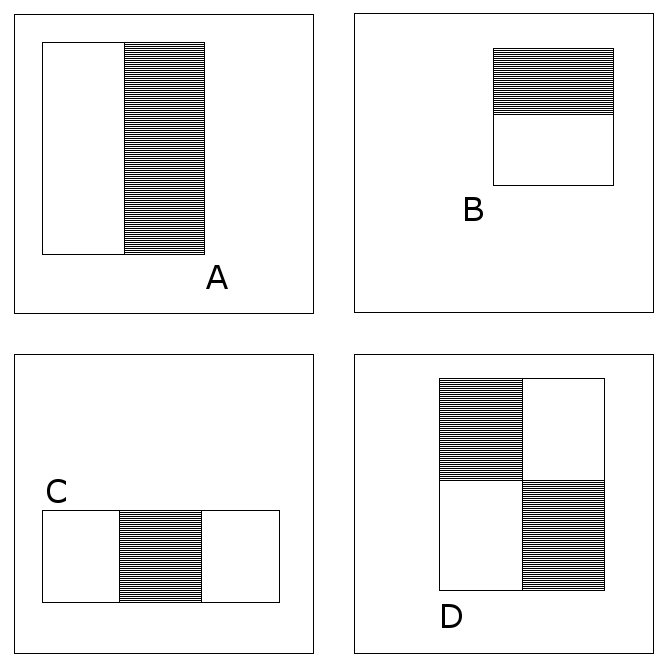

These features can be computed in constant time given an integral image (image containing cumulative sums over pixel values). Moreover, they do not require floating point arithmetics.

Early stages of the cascade used only a few features, nevertheless they were able to reject many non-faces, allowing larger tree-based classifiers where the features were used for splits.

We show below features used by first few stages, they intuitively react to the eye region and the nose:

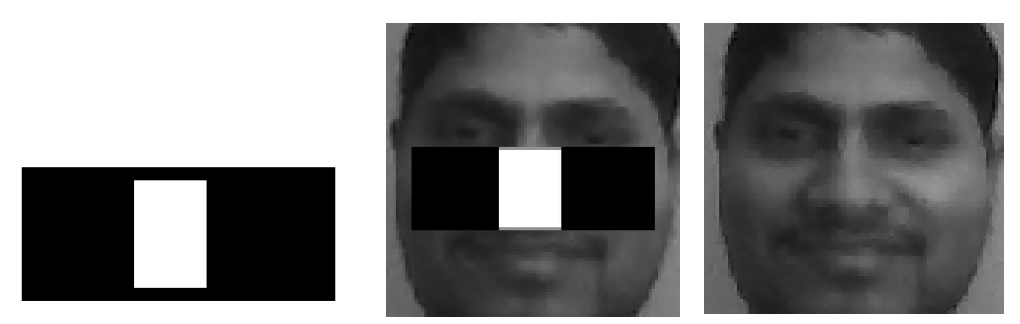
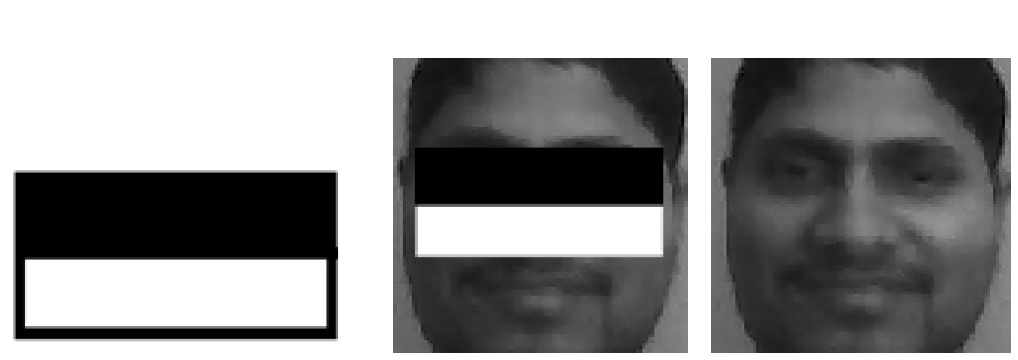

The Viola-Jones detector was trained using AdaBoost modified to support assymetrical errors: rejecting a face image was penalised more severely than keeping a non-face image.


# Conclusions

In this set of notes we have seen how ensembles may be built sequentially by adding classifiers that are forced to correct the operation of the ensemble. 

Boosted classifiers optimize a loss function on the data, by sequentially expanding an ensemble with additional classifiers. This approach can be interpreted as a greedy selection of data transformations

Boosted Decision Trees are very strong, broadly applicable models. Popular implementations of boosting such as XGBoost or the newer CatBoost or LightGBM has been used in winning solutions of many Kaggle contests. 

# Further reading
- Murphy, chapter 16.4
- [Elements of Statistical Learning](https://web.stanford.edu/~hastie/ElemStatLearn/), chapter 10
- [XGBoost paper]()
- XGBoost [intro](https://xgboost.readthedocs.io/en/latest/tutorials/model.html), [presentation](https://web.archive.org/web/20200415044009/https://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf), and [paper](https://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf).